<a href="https://colab.research.google.com/github/VenkyGitRep/Superresolution/blob/main/Super_resolution_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Code for Super resolution from Single image using CNNs
#CS7180 - Advanced Perception
#Submission by Venkateshwaran Sundar(sundar.ve@northeastern.edu)

In [ ]:
#Package Required
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage

In [ ]:
#PSNR implementation(can alternatively user cv2.pnsr)
def psnr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float64)
    ref_data = ref.astype(np.float64)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = np.sqrt(np.mean(diff ** 2.))

    return 20 * np.log10(255. / rmse)

In [ ]:
#Implementation of Mean Squared Error
def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)

    err /= np.float(target_data.shape[0] * target_data.shape[1])
    return err

In [ ]:
#SSIM - Structural Similarity is available from this package
from skimage.metrics import structural_similarity as ssim


In [ ]:
#Function that calculates combined metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores

In [ ]:
#Method to resize image. The idea is to use a raw image, downscale it and then upscale it back leading to loss of detail, intrurn introduction of noise.
#I perform this operation 5times, so the image gets distorted well. Origninal Set14 images are high resolution to begin with.
def prepare_images(path, factor):
    # Loop through the files in the directory
    for file in os.listdir(path):
        image = cv2.imread(path + '/' + file)

        # Find old and new image dimensions
        h, w, c = image.shape
        new_height = int(h / factor)
        new_width = int(w / factor)

        i=5
        while(i>0):
          # Resize down the image
          image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
          # Resize up the image
          image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
          i=i-1


        # Save the image
        try:
            os.listdir(path + '/../../SRCNN/resized')
        except:
            os.mkdir(path + '/../../SRCNN/resized')

        cv2.imwrite(path + '/../../SRCNN/resized/{}'.format(file), image)

In [ ]:
#Generate distorted images
prepare_images('/content/drive/MyDrive/SRCNN/SET14', 4)

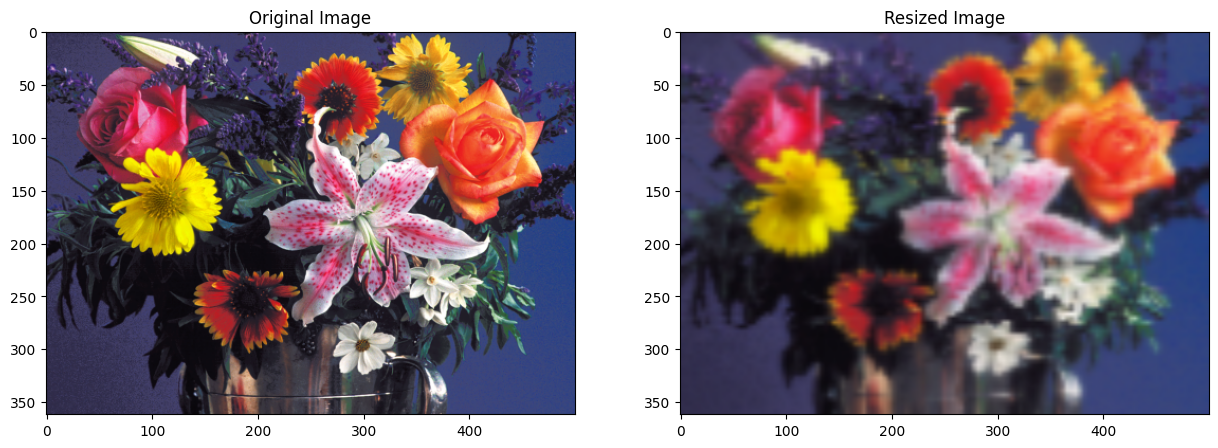

In [ ]:
#Display images next to each other
from PIL import Image
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('/content/drive/MyDrive/SRCNN/SET14/flowers.png'))
ax[0].title.set_text('Original Image')
ax[1].imshow(Image.open('/content/drive/MyDrive/SRCNN/resized/flowers.png'))
ax[1].title.set_text('Resized Image')
plt.show()

In [ ]:
#Compare metrics of reseized image
target = cv2.imread('/content/drive/MyDrive/SRCNN/SET14/flowers.png')
ref = cv2.imread('/content/drive/MyDrive/SRCNN/resized/flowers.png')

metrics = compare_images(target, ref)
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

<ipython-input-3-7301ac7b9fe7>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  err /= np.float(target_data.shape[0] * target_data.shape[1])
<ipython-input-5-a5e1d2f2bdb3>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel=True))


PSNR: 21.662970661878038
MSE: 1330.1620331491713
SSIM: 0.6126129440180104


In [ ]:
#Function to store images in Hierarchichal data format
# Build train dataset
import h5py

names = sorted(os.listdir('/content/drive/MyDrive/SRCNN/Train'))

data = []
label = []

for name in names:
    fpath = '/content/drive/MyDrive/SRCNN/Train/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape

    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

    width_range = int((shape[0] - 16 * 2) / 16)
    height_range = int((shape[1] - 16 * 2) / 16)

    for k in range(width_range):
        for j in range(height_range):
            x = k * 16
            y = j * 16

            hr_patch = hr_img[x: x + 32, y: y + 32]
            lr_patch = lr_img[x: x + 32, y: y + 32]

            hr_patch = hr_patch.astype(np.float32) / 255.
            lr_patch = lr_patch.astype(np.float32) / 255.

            hr = np.zeros((1, 20, 20), dtype=np.double)
            lr = np.zeros((1, 32, 32), dtype=np.double)

            hr[0, :, :] = hr_patch[6:-6, 6: -6]
            lr[0, :, :] = lr_patch

            label.append(hr)
            data.append(lr)

data = np.array(data, dtype=np.float32)
label = np.array(label, dtype=np.float32)

In [ ]:
with h5py.File('train.h5', 'w') as h:
    h.create_dataset('data', data=data, shape=data.shape)
    h.create_dataset('label', data=label, shape=label.shape)

In [ ]:
# Build test dataset

names = sorted(os.listdir('/content/drive/MyDrive/SRCNN/SET14'))
nums = len(names)

data_test = np.zeros((nums * 30, 1, 32, 32), dtype=np.double)
label_test = np.zeros((nums * 30, 1, 20, 20), dtype=np.double)

for i, name in enumerate(names):
    fpath = '/content/drive/MyDrive/SRCNN/SET14/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape

    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

    # Produce random crop
    x = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
    y = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)

    for j in range(30):
        lr_patch = lr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
        hr_patch = hr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]

        lr_patch = lr_patch.astype(np.float32) / 255.
        hr_patch = hr_patch.astype(np.float32) / 255.

        data_test[i * 30 + j, 0, :, :] = lr_patch
        label_test[i * 30 + j, 0, :, :] = hr_patch[6: -6, 6: -6]

In [ ]:
with h5py.File('test.h5', 'w') as h:
    h.create_dataset('data', data=data_test, shape=data_test.shape)
    h.create_dataset('label', data=label_test, shape=label_test.shape)

In [ ]:
#Use heirarchical images created in train.h5 and test.h5 to train and test model
def model():
    SRCNN = tf.keras.Sequential(name='SRCNN')
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9),
                                     padding='VALID',
                                     use_bias=True,
                                     input_shape=(None, None, 1),
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                     padding='SAME',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(5, 5),
                                     padding='VALID',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='linear'))
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

    # Compile model
    SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN

In [ ]:
srcnn_model = model()
srcnn_model.summary()

Model: "SRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   10496     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 85889 (335.50 KB)
Trainable params: 85889 (335.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Load dataset
import h5py
with h5py.File('/content/test.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = np.transpose(data, (0, 2, 3, 1))
    y_train = np.transpose(label, (0, 2, 3, 1))

with h5py.File('/content/test.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = np.transpose(data, (0, 2, 3, 1))
    y_test = np.transpose(label, (0, 2, 3, 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((420, 32, 32, 1), (420, 20, 20, 1), (420, 32, 32, 1), (420, 20, 20, 1))

In [ ]:
checkpoint_path = '/content/drive/MyDrive/SRCNN/checkpoint/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_best_only=True,
                                                 save_weights_only=True, verbose=0)

In [ ]:
srcnn_model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test),
                callbacks=[checkpoint], shuffle=True, epochs=200, verbose=True)

Epoch 1/200
7/7 [==============================] - 6s 739ms/step - loss: 0.1195 - mean_squared_error: 0.1195 - val_loss: 0.0484 - val_mean_squared_error: 0.0484
Epoch 2/200
7/7 [==============================] - 4s 661ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 3/200
7/7 [==============================] - 6s 837ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 4/200
7/7 [==============================] - 4s 665ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 5/200
7/7 [==============================] - 4s 668ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 6/200
7/7 [==============================] - 5s 726ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 7/200
7/7 [=================

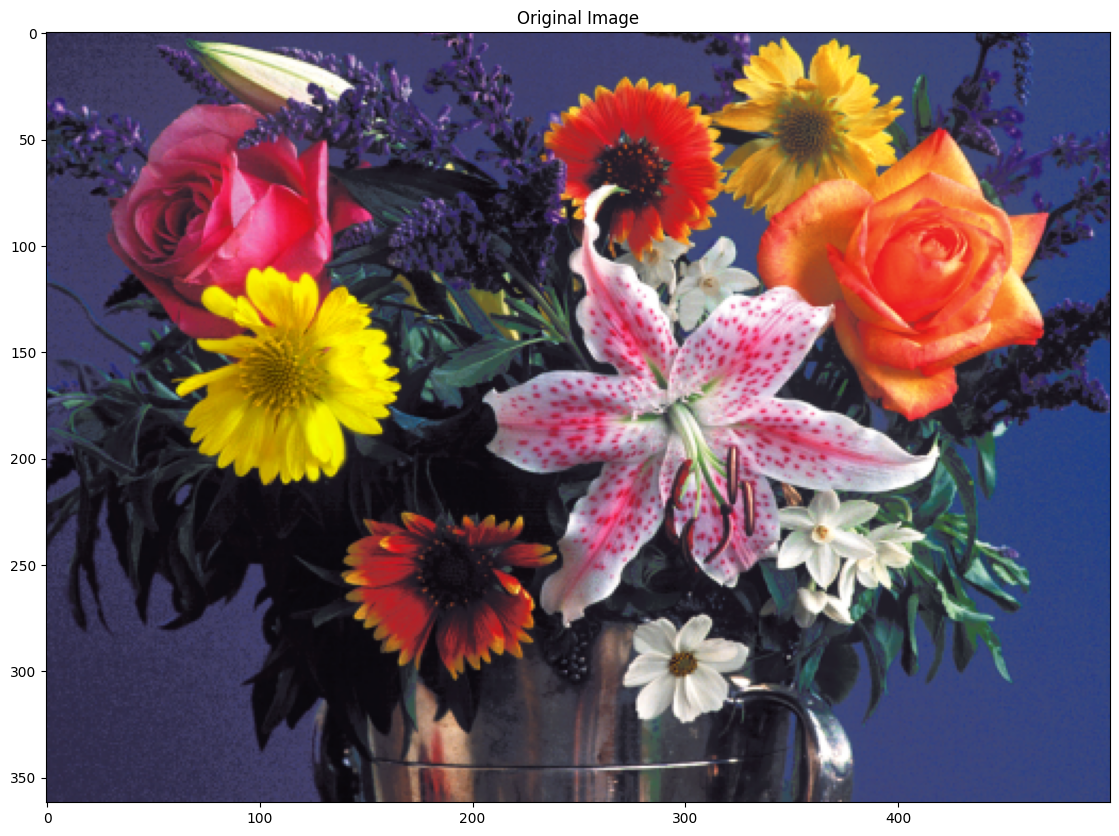

In [ ]:
#Perform Superresolution
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/content/drive/MyDrive/SRCNN/SET14/flowers.png'))
ax.title.set_text("Original Image")
plt.show()

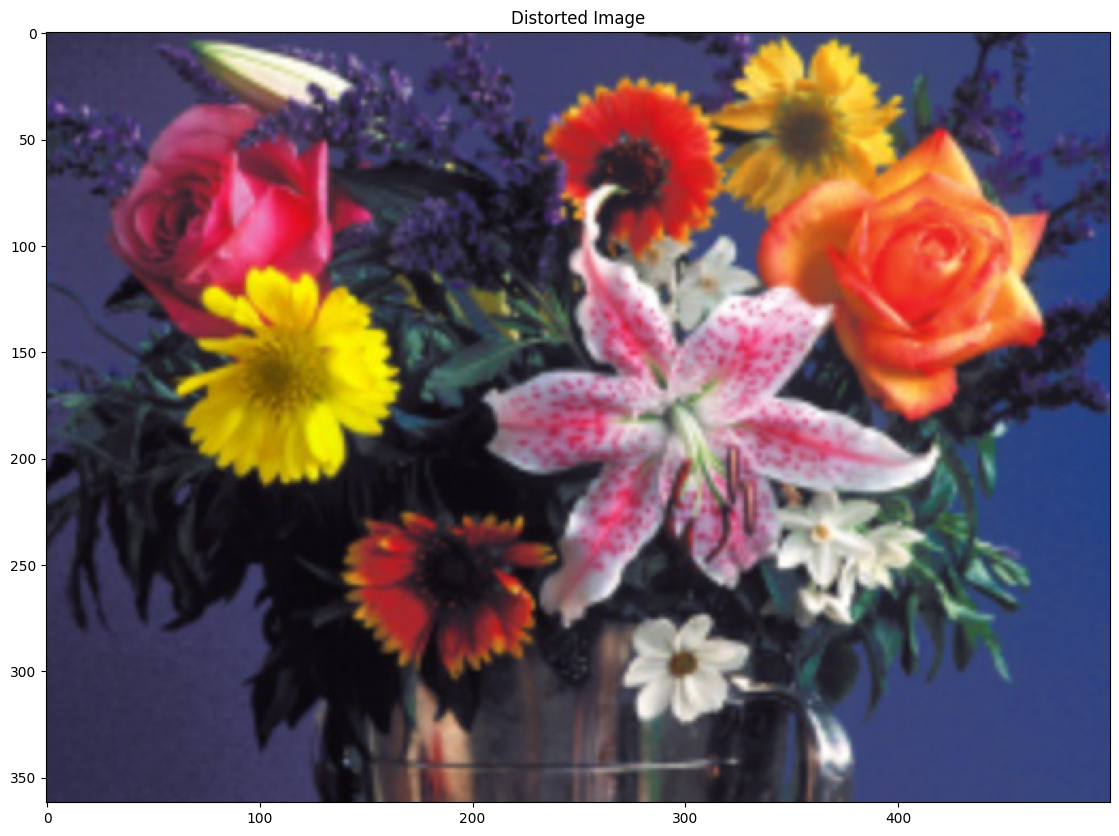

In [ ]:
#Creating low resolution image
try:
    os.listdir('/content/drive/MyDrive/SRCNN/output')
except:
    os.mkdir('/content/drive/MyDrive/SRCNN/output')

target = cv2.imread('/content/drive/MyDrive/SRCNN/SET14/flowers.png', cv2.IMREAD_COLOR)
target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
shape = target.shape

# Resize down by scale of 2
Y_img = cv2.resize(target[:, :, 0], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)

# Resize up to orignal image
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
target[:, :, 0] = Y_img
target = cv2.cvtColor(target, cv2.COLOR_YCrCb2BGR)
cv2.imwrite('/content/drive/MyDrive/SRCNN/output/input.jpg', target)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/content/drive/MyDrive/SRCNN/output/input.jpg'))
ax.title.set_text("Distorted Image")
plt.show()

1/1 [==============================] - 1s 732ms/step


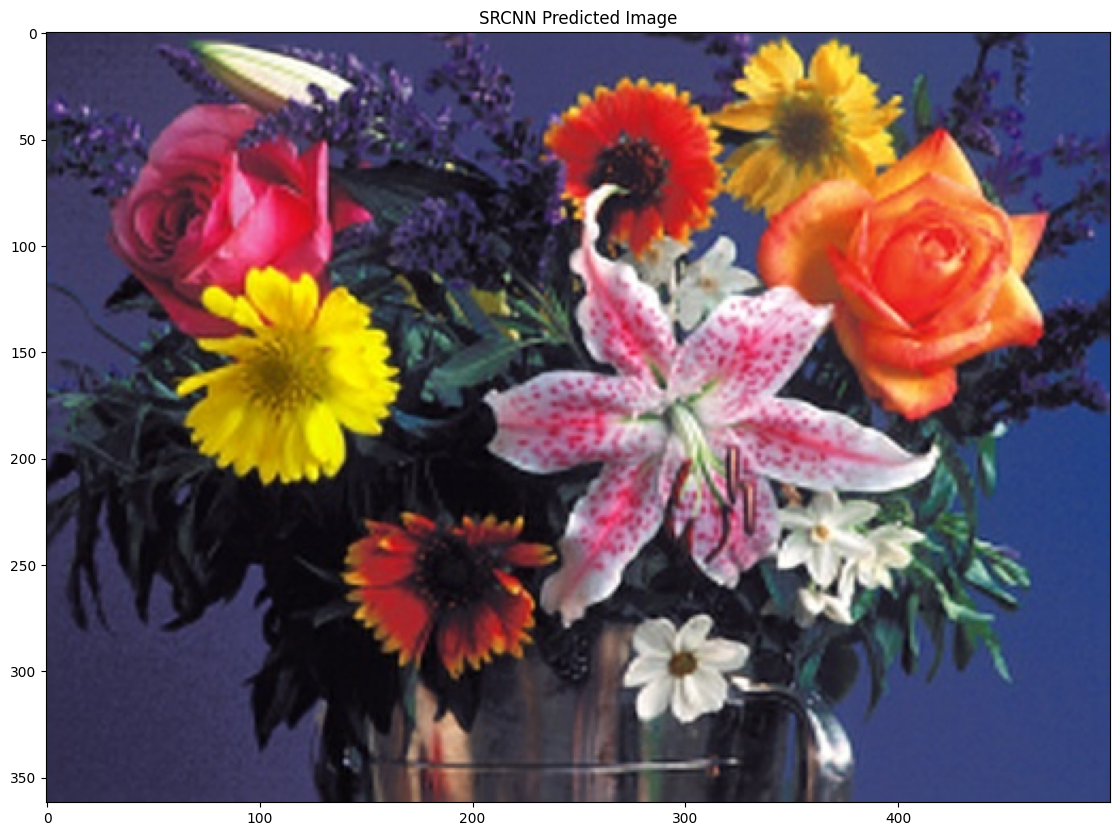

In [ ]:
Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
# Normalize
Y[0, :, :, 0] = Y_img.astype(np.float32) / 255.

# Predict
pre = srcnn_model.predict(Y, batch_size=1) * 255.

# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

# Copy y channel back to image and convert to BGR
output = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
output[6: -6, 6: -6, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

# Save image
cv2.imwrite('/content/drive/MyDrive/SRCNN/output/output.jpg', output)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/content/drive/MyDrive/SRCNN/output/output.jpg'))
ax.title.set_text("SRCNN Predicted Image")
plt.show()

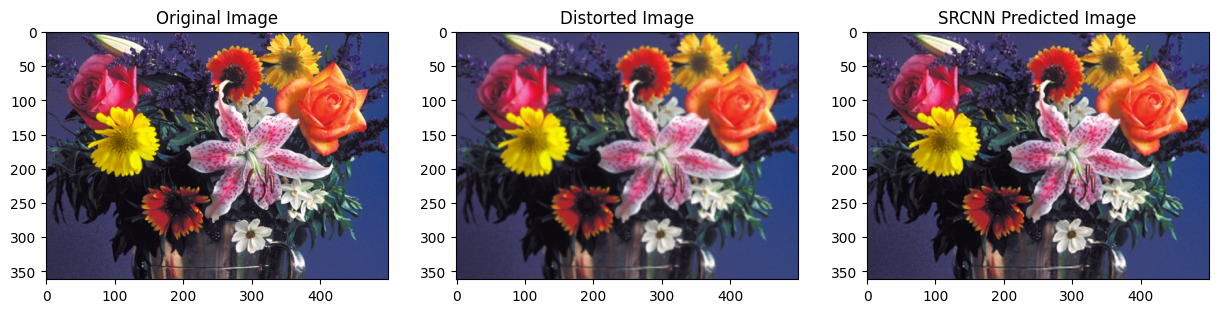

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(Image.open('/content/drive/MyDrive/SRCNN/SET14/flowers.png'))
ax[0].title.set_text("Original Image")

ax[1].imshow(Image.open('/content/drive/MyDrive/SRCNN/output/input.jpg'))
ax[1].title.set_text("Distorted Image")

ax[2].imshow(Image.open('/content/drive/MyDrive/SRCNN/output/output.jpg'))
ax[2].title.set_text("SRCNN Predicted Image")

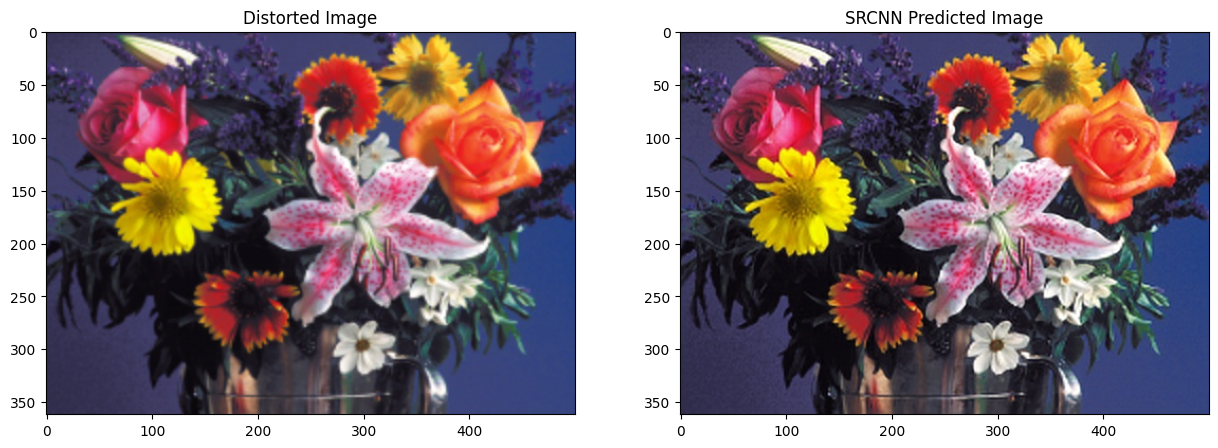

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('/content/drive/MyDrive/SRCNN/output/input.jpg'))
ax[0].title.set_text("Distorted Image")

ax[1].imshow(Image.open('/content/drive/MyDrive/SRCNN/output/output.jpg'))
ax[1].title.set_text("SRCNN Predicted Image")

In [ ]:
original = cv2.imread('/content/drive/MyDrive/SRCNN/SET14/flowers.png')
distorted = cv2.imread('/content/drive/MyDrive/SRCNN/output/input.jpg')
predicted = cv2.imread('/content/drive/MyDrive/SRCNN/output/output.jpg')

In [ ]:
metrics = compare_images(original, distorted)
print("Metrics for original and distorted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and distorted image
PSNR: 27.285283674243583
MSE: 364.47958011049724
SSIM: 0.8494841772541553


<ipython-input-3-7301ac7b9fe7>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  err /= np.float(target_data.shape[0] * target_data.shape[1])
<ipython-input-5-a5e1d2f2bdb3>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel=True))


In [ ]:
#Metrics comparison between original and predicted image
metrics = compare_images(original, predicted)
print("Metrics for original and predicted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))


Metrics for original and predicted image
PSNR: 28.718686659382932
MSE: 262.01911602209947
SSIM: 0.8719819830434178


<ipython-input-3-7301ac7b9fe7>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  err /= np.float(target_data.shape[0] * target_data.shape[1])
<ipython-input-5-a5e1d2f2bdb3>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel=True))



PSNR is an imporvement relative to the distorted image. However, its no where near the PSNR of the more sophistaicated approaches discussed in papers we went over in class which use GANs and Transformers. This was my attempt at implementing Superresolution using CNNs from a single image. It does a good job, i'd be interested in running this model on realworld data(image that is low resoultion to begin with) to see how it actually peforms. And them compare results with the more sophisticated models discussed in class.

References :

1.   Super-Resolution Convolutional Neural Network: https://goodboychan.github.io/python/deep_learning/vision/tensorflow-keras/2020/10/13/01-Super-Resolution-CNN.html
2.   Chao Dong, Chen Change Loy, Kaiming He, and Xiaoou Tang, "Learning a Deep Convolutional Network for Image Super-Resolution", ECCV, 2014.


